# 股债配置和再平衡策略

### 第六组：

王梦瑶 2020213448  
谭卓尔 2020213444  
严璐安 2020213454  
黄昊 2020213493  
严文 2020213538

### 小组分工：

**数据爬取**：谭卓尔，王梦瑶，严璐安  
**数据分析**：全体成员  
**GUI封装**：王梦瑶，严璐安  
**可视化**：黄昊，严文  
**文档整理**：王梦瑶    
**课堂展示**：谭卓尔，王梦瑶

## 一、数据爬取

In [1]:
import sys
import json
import urllib as UrlUtils
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import requests
from lxml import etree
import time
import json
from IPython.display import Image

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

C:\Users\Administrator\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
class Download_HistoryStock(object):
    def __init__(self, code):
        self.code = code
        self.start_url = "http://quotes.money.163.com/trade/lsjysj_zhishu_" + self.code[1::] + ".html"
        print (self.start_url)
        self.headers = {
        "User-Agent": ":Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36"
        }

    def parse_url(self):
        response = requests.get(self.start_url)
        print (response.status_code)
        if response.status_code == 200:
            return etree.HTML(response.content)
        return False

    def get_date(self, response):
    # 得到开始和结束的日期
    #方式是去掉"-"
        start_date = ''.join(response.xpath('//input[@name="date_start_type"]/@value')[0].split('-'))
        end_date = ''.join(response.xpath('//input[@name="date_end_type"]/@value')[0].split('-'))
        return start_date,end_date
    

    def download(self, start_date, end_date):
        download_url = "http://quotes.money.163.com/service/chddata.html?code="+self.code+"&start"+start_date+"&end="+end_date+"&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER"
        data = requests.get(download_url)
        with open(self.code[1::] + '.csv', 'wb') as f:
            print ('股票---',self.code,'历史数据正在下载')
            for chunk in data.iter_content(chunk_size=10000):                
                f.write(chunk)

    def run(self):
        try:
            html = self.parse_url()
            start_date,end_date = self.get_date(html)
            self.download(start_date, end_date)
        except Exception as e:
            print (e)

            
#可供参考的download_url
# http://quotes.money.163.com/service/chddata.html?code=0600000&start=19991110&end=20201120&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP
# http://quotes.money.163.com/service/chddata.html?code=1399300&start=20020104&end=20201120&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER
# http://quotes.money.163.com/service/chddata.html?code=0000012&start=20030224&end=20201120&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER
# http://quotes.money.163.com/service/chddata.html?code=0000001&start=19901219&end=20201120&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER
# http://quotes.money.163.com/service/chddata.html?code=0000017&start=20060104&end=20201120&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER
# http://quotes.money.163.com/service/chddata.html?code=1002415&start=20100517&end=20201120&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;TURNOVER;VOTURNOVER;VATURNOVER;TCAP;MCAP

In [3]:
if __name__ == '__main__':
    code_list = ['1399300','0000012']
#若股票、债券或指数位于沪市，请在代码前加上0，若位于深市，请在代码前加上1
for temp_code in code_list:
    time.sleep(1)
    download = Download_HistoryStock(temp_code)
    download.run()

http://quotes.money.163.com/trade/lsjysj_zhishu_399300.html
200
股票--- 1399300 历史数据正在下载
http://quotes.money.163.com/trade/lsjysj_zhishu_000012.html
200
股票--- 0000012 历史数据正在下载


## 二、数据整理

### (一)获取收盘价时间序列

In [7]:
#现在我们成功的从文件中读取了沪深300指数的历史数据。但是我们发现，这些原始数据中还是存在着一些问题：
#问题一：这里面的时间是倒排的。也就是说最新时间对应的数据在最前面，而最老的数据却在后面，这个和我们所需要的正好相反。因此我们需要进行逆序调整，把老的数据放在前面，而把最新的数据放在最后。
#问题二：这并不是一个严格意义上的时间序列。因为此时的索引是流水ID号，而不是日期类型数据，日期存放在了一个属性列当中。
#问题三：日期数据是字符串类型，无法直接进行计算处理。因此为了方便后续的处理，我们需要将字符串类型的日期数据转换成pandas中的时间戳类型，并将此作为时间序列的索引。

df = pd.read_csv('399300.csv', encoding='gbk')
df.head()

,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,成交量,成交金额
0,2020-11-20,'399300,沪深300,4943.2882,4947.4297,4922.5895,4928.2223,4927.9891,15.2991,0.3105,12940034100,2.290537e+11
1,2020-11-19,'399300,沪深300,4927.9891,4939.7911,4870.2005,4880.9224,4891.6716,36.3175,0.7424,13368137800,2.477271e+11
2,2020-11-18,'399300,沪深300,4891.6716,4911.0876,4870.7162,4889.6749,4894.786,-3.1144,-0.0636,16421661600,2.907272e+11
3,2020-11-17,'399300,沪深300,4894.7860,4909.2902,4865.3942,4903.1200,4904.1716,-9.3856,-0.1914,15148746400,2.889114e+11
4,2020-11-16,'399300,沪深300,4904.1716,4904.1716,4848.6239,4880.9580,4856.8513,47.3203,0.9743,14877098000,2.667050e+11


In [8]:
df.dtypes

日期       object
股票代码     object
名称       object
收盘价     float64
最高价     float64
最低价     float64
开盘价     float64
前收盘      object
涨跌额      object
涨跌幅      object
成交量       int64
成交金额    float64
dtype: object

可以看到“日期”列格式为字符串类型，需要将其转换为时间类型

In [9]:
df = df.reindex(index=df.index[::-1])#调整顺序
df['日期']=pd.to_datetime(df['日期'])#转换为时间类型
df.set_index('日期', inplace=True)#将索引设置为日期
#将字符串类型的时间字符串转换成pandas中的时间戳类型，并且我们只选取收盘价数据，最终得到一个series类型的时间序列。
ser=df['收盘价']
print(ser)

日期
2002-01-04    1316.4600
2002-01-07    1302.0800
2002-01-08    1292.7100
2002-01-09    1272.6500
2002-01-10    1281.2600
2002-01-11    1249.8100
2002-01-14    1205.1500
2002-01-15    1186.4300
2002-01-16    1201.8800
2002-01-17    1152.1500
2002-01-18    1149.4800
2002-01-21    1108.6100
2002-01-22    1109.9900
2002-01-23    1183.1500
2002-01-24    1189.5800
2002-01-25    1189.4300
2002-01-28    1112.8300
2002-01-29    1140.3800
2002-01-30    1145.8600
2002-01-31    1221.7600
2002-02-01    1215.7400
2002-02-04    1236.9700
2002-02-05    1246.8400
2002-02-06    1216.7900
2002-02-07    1241.0200
2002-02-08    1235.0900
2002-02-25    1254.6100
2002-02-26    1253.1200
2002-02-27    1256.0000
2002-02-28    1244.6000
2002-03-01    1227.2300
2002-03-04    1245.8700
2002-03-05    1275.6100
2002-03-06    1288.4400
2002-03-07    1328.3900
2002-03-08    1351.8500
2002-03-11    1377.0400
2002-03-12    1362.4000
2002-03-13    1343.1400
2002-03-14    1376.3300
2002-03-15    1338.7000
2002-03-18   

In [10]:
ser.shape

(4581,)

### (二)封装获取某只股票或债券收盘价时间序列的函数get_data_ser

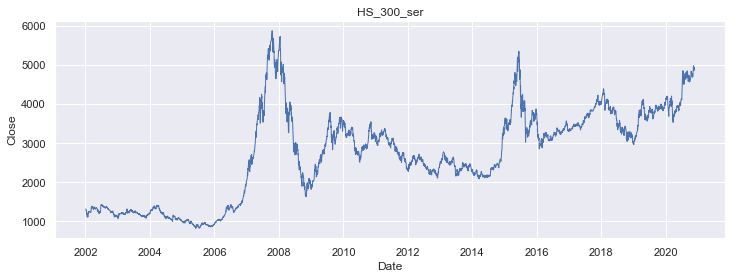

In [11]:
#为了后面方便的进行功能复用，我们把这段代码封装进一个函数，并绘制出沪深300指数的历史每日收盘价，便于我们进行观察。
import seaborn as sns
sns.set()

def get_data_ser(index_code):
    csv_name = index_code+'.csv'
    df = pd.read_csv(csv_name, encoding='gbk')
    df['日期']=pd.to_datetime(df['日期'])
    df = df.reindex(index=df.index[::-1])
    df.set_index('日期', inplace=True)

    ser = df['收盘价']
    return ser

HS_300_ser = get_data_ser('399300')
plt.figure(figsize=(12,4))
plt.plot(HS_300_ser,"b",linewidth=1)   #在当前绘图对象绘图（蓝色线，线宽度）  
plt.xlabel("Date") #X轴标签  
plt.ylabel("Close")  #Y轴标签  
plt.title("HS_300_ser") #图标题  
plt.show()

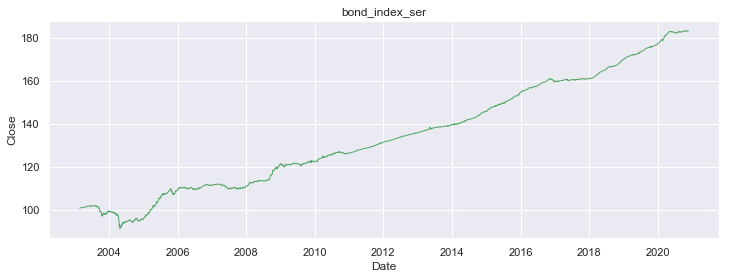

In [12]:
bond_index_ser = get_data_ser('000012')
plt.figure(figsize=(12,4))
plt.plot(bond_index_ser,"g",linewidth=1)   #在当前绘图对象绘图（绿色线，线宽度）  
plt.xlabel("Date") #X轴标签  
plt.ylabel("Close")  #Y轴标签  
plt.title("bond_index_ser") #图标题  
plt.show()

### (三)升级函数get_data_ser，增加选定时间范围功能

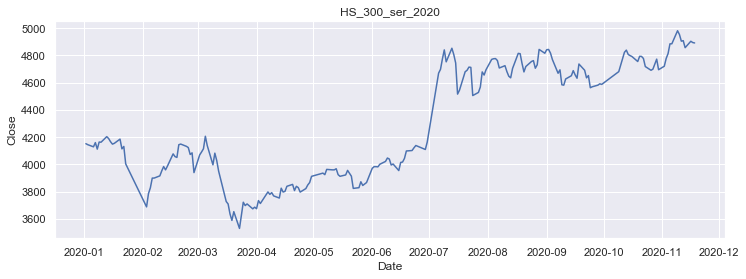

In [13]:
#这里我们再补充一点，如果我们不想看所有的历史数据，而只是想选择特定时间范围内的数据进行观察，那么又该如何操作？
#我们对get_data_ser这个函数进行一些修改，利用Series数据索引中的条件掩码，可以非常容易的实现上述需求。例如，我们想看看今年以来沪深300指数的表现情况：

def get_data_ser(index_code, begin_date, end_date):
    csv_name = index_code+'.csv'
    df = pd.read_csv(csv_name,encoding='gbk')
    df['日期']=pd.to_datetime(df['日期'])
    df = df.reindex(index=df.index[::-1])
    df.set_index('日期', inplace=True)
    
    ser = df['收盘价']
    select_date = pd.date_range(begin_date, end_date)
    select_ser = ser[ser.index.isin(select_date)]

    return select_ser

HS_300_ser_2020 = get_data_ser('399300', '2020-1-1', '2020-11-18')
plt.figure(figsize=(12,4))
plt.plot(HS_300_ser_2020,"b",linewidth=1.5)   #在当前绘图对象绘图（蓝色线，线宽度）  
plt.xlabel("Date") #X轴标签  
plt.ylabel("Close")  #Y轴标签  
plt.title("HS_300_ser_2020") #图标题  
plt.show()

## 三、比较股债年化收益率和波动性的区别

### (一)年化收益率的计算

#### 1.封装函数get_annual_ret_rate，可根据股票代码和起始、截止日期计算年化收益率

In [14]:
def get_annual_ret_rate(index_code, begin_date, end_date):
    ser = get_data_ser(index_code, begin_date, end_date)
    total_trading_day = len(ser.index)
    annual_trading_day = 244
    final_net_worth = ser.iloc[total_trading_day - 1]#股票最终价值
    initial_net_worth = ser.iloc[0]#股票初始价值
    
    #pow(x,y):表示x的y次幂
    annual_ret_rate = pow((final_net_worth / initial_net_worth), (annual_trading_day / total_trading_day)) - 1
    annual_ret_rate = '%.2f%%' % (annual_ret_rate * 100)#将小数转化为百分数
    return annual_ret_rate

print('沪深300指数年化收益率：')
print('近3年：{}'.format(get_annual_ret_rate('399300', '2017-11-18', '2020-11-18')))
print('近5年：{}'.format(get_annual_ret_rate('399300', '2015-11-18', '2020-11-18')))
print('近10年：{}'.format(get_annual_ret_rate('399300', '2010-11-18','2020-11-18')))
print('近15年：{}'.format(get_annual_ret_rate('399300', '2005-11-18', '2020-11-18')))
print('国债指数年化收益率：')
print('近3年：{}'.format(get_annual_ret_rate('000012', '2017-11-18', '2020-11-18')))
print('近5年：{}'.format(get_annual_ret_rate('000012', '2015-11-18', '2020-11-18')))
print('近10年：{}'.format(get_annual_ret_rate('000012', '2010-11-18','2020-11-18')))
print('近15年：{}'.format(get_annual_ret_rate('000012', '2005-11-18', '2020-11-18')))

沪深300指数年化收益率：
近3年：5.71%
近5年：5.66%
近10年：4.52%
近15年：12.14%
国债指数年化收益率：
近3年：4.45%
近5年：3.67%
近10年：3.81%
近15年：3.65%


- 从程序的运行结果中可以发现，沪深300指数如果买点不同，年化收益率的差距其实是非常大的，而国债指数的差距则相对要小很多。

- 换句话说，沪深300指数的每日净值波动非常大，如果一不小心买在山顶，则很有可能承受较大的亏损和较长时间的“套牢”，因此高收益下隐含的是高风险。而国债指数的整个曲线是稳稳向上的，虽然收益率较低，但不那么惊心动魄，属于稳稳的幸福。

#### 2.股债比较
- 我们把沪深300指数和国债指数放在一张图里来观察会更加直观一些。但要强调一点的是，我们必须对两个序列的值进行**归一化**处理，即让沪深300指数和国债指数的净值在起始日期都变成1。

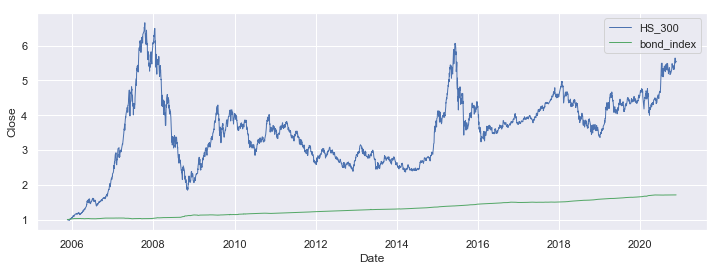

In [15]:
HS_300 = get_data_ser('399300','2005-11-18', '2020-11-18')
HS_300 = HS_300/HS_300.iloc[0]
bond_index = get_data_ser('000012','2005-11-18', '2020-11-18')
bond_index = bond_index/bond_index.iloc[0]
df = pd.DataFrame({'HS_300':HS_300,
                   'bond_index':bond_index})

plt.figure(figsize=(12,4))
plt.plot(HS_300,"b",linewidth=1,label='HS_300')
plt.plot(bond_index, "g",linewidth=1,label='bond_index')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

### (二)年化波动率的计算

- 年化波动率=日收益率的标准差 $\times$ $\sqrt{年交易日}$

- 由于波动率的计算需要获取指数的每日收益率数据，因此我们进一步改造get_data_ser函数，使他能够获取任意指定的属性列。

#### 1.升级get_data_ser函数，增加获取指定属性列的功能

In [16]:
def get_data_ser(index_code, begin_date, end_date, col_name):
    csv_name = index_code+'.csv'
    df = pd.read_csv(csv_name,encoding='gbk')
    df['日期']=pd.to_datetime(df['日期'])
    df = df.reindex(index=df.index[::-1])
    df.set_index('日期', inplace=True)
    
    ser = df[col_name]
    select_date = pd.date_range(begin_date, end_date)
    select_ser = ser[ser.index.isin(select_date)]

    return select_ser

In [17]:
#波动率的函数
from math import sqrt

def get_volatility(index_code, begin_date, end_date):
    annual_trading_day = 244
    ser = get_data_ser(index_code,begin_date,end_date,'涨跌幅')
    ser = pd.to_numeric(ser)
    ser = ser / 100
    volatility = ser.std()*sqrt(annual_trading_day)

    return volatility

#### 2.股债比较

In [18]:
HS_300_volatility = get_volatility('399300','2005-11-18', '2020-11-18')
HS_300_volatility = '%.2f%%' % (HS_300_volatility * 100)
bond_index_volatility = get_volatility('000012','2005-11-18', '2020-11-18')
bond_index_volatility = '%.2f%%' % (bond_index_volatility * 100)

print("近15年来指数的波动率")
print("沪深300指数：{}".format(HS_300_volatility))
print("国债指数：{}".format(bond_index_volatility))

近15年来指数的波动率
沪深300指数：26.94%
国债指数：0.96%


## 四、股债配置和再平衡策略

### (一)模型一：单纯的比例模型

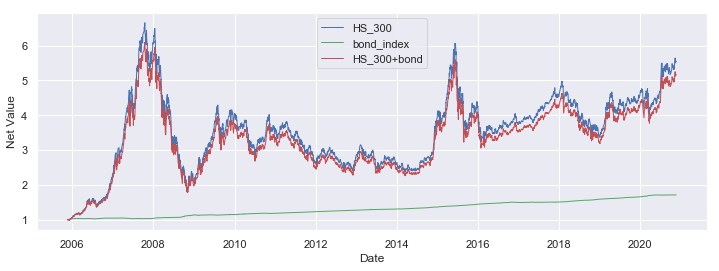

In [19]:
#归一化
HS_300 = get_data_ser('399300','2005-11-18', '2020-11-18','收盘价')
HS_300_pay = HS_300/HS_300.iloc[0]
bond_index = get_data_ser('000012','2005-11-18', '2020-11-18','收盘价')
bond_index_pay = bond_index/bond_index.iloc[0]

HS_with_bond = 0.9*HS_300_pay+0.1*bond_index_pay
df = pd.DataFrame({'HS_300':HS_300_pay,'bond_index':bond_index_pay,'HS_300+bond':HS_with_bond})

plt.figure(figsize=(12,4))
plt.plot(HS_300_pay,"b",linewidth=1,label='HS_300')
plt.plot(bond_index_pay, "g",linewidth=1,label='bond_index')
plt.plot(HS_with_bond, "r",linewidth=1,label='HS_300+bond')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Net Value")
plt.show()

在图中，红色的曲线就是沪深300指数和国债指数做1:1配置后的组合净值曲线，很明显，组合后的收益率要高于国债指数而波动率又低于沪深300指数。

但是我们是不是止步于此了呢？不，这显然过于简单了，我们再加入一些策略，来优化我们的净值曲线，目前比较主流的一种策略叫作：股债平衡策略。

这个策略具体描述为：在初始配置时，设定一个股债的资金分配比例，常见的有5：5，7：3等等，由于股票指数和债券指数的收益率、波动率差异很大。慢慢的，随着时间的发展，二者的净值比例显然就不再等于原始设定的比例了，碰上大熊或者大牛之年，比例偏离的可能会非常大。

那么，此时就引入了平衡策略，要求每隔一年，将股和债的资金配比恢复到初始配比值，即完成一次再平衡。由于股和债的相关性很低，在某种程度上甚至形成负相关，因此，这种策略能够在一定程度上动态的对所持股债资产进行高抛低吸，能够兼顾低波动率和高收益率两个目标。

在一些文章中还介绍说，运用了股债平衡策略的资产组合，其收益率甚至可以超过单纯只配置股票指数的收益率。

### (二)模型二：股债平衡策略

#### 定义股债再平衡函数get_stock_with_bond

In [20]:
#传入函数的参数stock_share和bond_share表示我们指定的股票指数和债券指数各自所占的资金比例
def get_stock_with_bond(stock_code,stock_share,bond_code,bond_share,begin_date,end_date):
    #获取指定日期区间内的股票指数和债券指数数据，并进行归一化处理，统一将第一天的每份净值都设置为1。
    stock_ser = get_data_ser(stock_code, begin_date, end_date, '收盘价')
    stock_ser = stock_ser / stock_ser.iloc[0]
    bond_ser = get_data_ser(bond_code, begin_date, end_date, '收盘价')
    bond_ser = bond_ser / bond_ser.iloc[0]
    comb_ser = pd.Series(index=stock_ser.index)#初始化用来表示股债资产组合的Series对象，此时他的每日净值均为NaN。
    
    

    stock_unit = stock_share
    bond_unit = bond_share
    #stock_unit和bond_unit表示每日股票指数和债券指数的持有份数，我们定义：
    #股票份数=股票总资金量/股票指数每份净值。由于经过我们的归一化处理后，股票指数、债券指数在起始日的每份净值均为1，
    #因此组合资产中初始的股票指数份数即为：stock_unit=stock_share，债券指数份数即为：bond_unit=bond_share。组合资产的起始净值也为1。
    
    for i in range(len(stock_ser.index)):
        #每日将组合中各类资产的每份净值乘以份数再相加，就得到了组合资产的当日净值。
        comb_ser.iloc[i] =stock_unit*stock_ser.iloc[i]+bond_unit*bond_ser.iloc[i]
        if i % 244 == 0 and i != 0:
            stock_unit = (stock_share*comb_ser.iloc[i])/stock_ser.iloc[i]
            bond_unit = (bond_share*comb_ser.iloc[i])/bond_ser.iloc[i]
        #每隔一年（这里就设定为每244个交易日），将组合资产当日的净值按照设定的股债资金比例重新分配，得到新的股票总资金量和债券总资金量
        #通过分别除以各类资产的当日每份净值，就得到此时新的股票份数和债券份数。

    return comb_ser

In [22]:
comb_ser55 = get_stock_with_bond('399300',0.5,'000012',0.5,'2005-11-18', '2020-11-18')
comb_ser91 = get_stock_with_bond('399300',0.9,'000012',0.1,'2005-11-18', '2020-11-18')
HS_300 = get_data_ser('399300','2005-11-18', '2020-11-18','收盘价')
HS_300 = HS_300/HS_300.iloc[0]
bond_index = get_data_ser('000012','2005-11-18', '2020-11-18','收盘价')
bond_index = bond_index/bond_index.iloc[0]

df = pd.DataFrame({'HS_300':HS_300,
                   'bond_index':bond_index,
                   'smart_55':comb_ser55,
                   'smart_91':comb_ser91})

**可视化**

In [23]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK

import pyecharts.options as opts
from pyecharts.charts import Line


x=HS_300.index

line=(
    Line()
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="资产配置有效性",
            subtitle = "By HUANG HAO",
            pos_left="center",
            pos_top="20",
        ),
        tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
        legend_opts=opts.LegendOpts(pos_left="left"),
        datazoom_opts=[
            opts.DataZoomOpts(range_start=0, range_end=100),
            opts.DataZoomOpts(type_="inside", range_start=0, range_end=100),
        ],
        xaxis_opts=opts.AxisOpts(type_="category", boundary_gap=False),
        yaxis_opts=opts.AxisOpts(name="value", 
                                 type_="value",
                                 axistick_opts=opts.AxisTickOpts(is_show=True),
                                 splitline_opts=opts.SplitLineOpts(is_show=True)),
    )
    .add_xaxis(xaxis_data = x)
    .add_yaxis(
        series_name="HS_300",
        y_axis=HS_300,
        symbol="emptyCircle",
        areastyle_opts=opts.AreaStyleOpts(opacity=0.05),
        linestyle_opts=opts.LineStyleOpts(),
        label_opts=opts.LabelOpts(is_show=False),
    )
    .add_yaxis(
    series_name="bond_index",
    y_axis=bond_index,
    symbol="emptyCircle",
    areastyle_opts=opts.AreaStyleOpts(opacity=0.05),
    linestyle_opts=opts.LineStyleOpts(),
    label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
    series_name="50%HS+50%bond",
    y_axis=comb_ser55,
    symbol="emptyCircle",
    areastyle_opts=opts.AreaStyleOpts(opacity=0.05),
    linestyle_opts=opts.LineStyleOpts(),
    label_opts=opts.LabelOpts(is_show=False),
)
    .add_yaxis(
    series_name="90%HS+10%bond",
    y_axis=comb_ser91,
    symbol="emptyCircle",
    areastyle_opts=opts.AreaStyleOpts(opacity=0.05),
    linestyle_opts=opts.LineStyleOpts(),
    label_opts=opts.LabelOpts(is_show=False),
)
)
    

line.render_notebook()

## 五、结论

从上图可知，在较长的一段时期内，股债净值比为9比1的投资组合的净值是超过沪深300指数的，可以得出：股债平衡策略是有效的。这说明，每隔一年将股和债的资金配比恢复到初始配比值的再平衡策略，确实能够在一定程度上对所持股债资产进行动态的高抛低吸，能够兼顾低波动率和高收益率两个目标。


## 六、GUI封装

**将代码封装为简介的GUI界面，使用简便，更具美观度，可作为课堂教学工具**  

### (一)所需函数
- Download_HistoryStock爬虫函数
- get_data_ser获取时间序列函数
- get_stock_with_bond股债再平衡函数


In [3]:
def get_data_ser(index_code, begin_date, end_date, col_name):
    csv_name = index_code+'.csv'
    df = pd.read_csv(csv_name,encoding='gbk')
    df['日期']=pd.to_datetime(df['日期'])
    df = df.reindex(index=df.index[::-1])
    df.set_index('日期', inplace=True)
    
    ser = df[col_name]
    select_date = pd.date_range(begin_date, end_date)
    select_ser = ser[ser.index.isin(select_date)]

    return select_ser

In [4]:
def get_stock_with_bond(stock_code,stock_share,bond_code,bond_share,begin_date,end_date):
    #获取指定日期区间内的股票指数和债券指数数据，并进行归一化处理，统一将第一天的每份净值都设置为1。
    stock_ser = get_data_ser(stock_code, begin_date, end_date, '收盘价')
    stock_ser = stock_ser / stock_ser.iloc[0]
    bond_ser = get_data_ser(bond_code, begin_date, end_date, '收盘价')
    bond_ser = bond_ser / bond_ser.iloc[0]
    comb_ser = pd.Series(index=stock_ser.index)#初始化用来表示股债资产组合的Series对象，此时他的每日净值均为NaN。
    
    

    stock_unit = stock_share
    bond_unit = bond_share
    #stock_unit和bond_unit表示每日股票指数和债券指数的持有份数，我们定义：
    #股票份数=股票总资金量/股票指数每份净值。由于经过我们的归一化处理后，股票指数、债券指数在起始日的每份净值均为1，
    #因此组合资产中初始的股票指数份数即为：stock_unit=stock_share，债券指数份数即为：bond_unit=bond_share。组合资产的起始净值也为1。
    
    for i in range(len(stock_ser.index)):
        #每日将组合中各类资产的每份净值乘以份数再相加，就得到了组合资产的当日净值。
        comb_ser.iloc[i] =stock_unit*stock_ser.iloc[i]+bond_unit*bond_ser.iloc[i]
        if i % 244 == 0 and i != 0:
            stock_unit = (stock_share*comb_ser.iloc[i])/stock_ser.iloc[i]
            bond_unit = (bond_share*comb_ser.iloc[i])/bond_ser.iloc[i]
        #每隔一年（这里就设定为每244个交易日），将组合资产当日的净值按照设定的股债资金比例重新分配，得到新的股票总资金量和债券总资金量
        #通过分别除以各类资产的当日每份净值，就得到此时新的股票份数和债券份数。

    return comb_ser

### (二)构造GUI界面

http://quotes.money.163.com/trade/lsjysj_zhishu_399300.html
http://quotes.money.163.com/trade/lsjysj_zhishu_000012.html
200
股票--- 1399300 历史数据正在下载
200
股票--- 0000012 历史数据正在下载


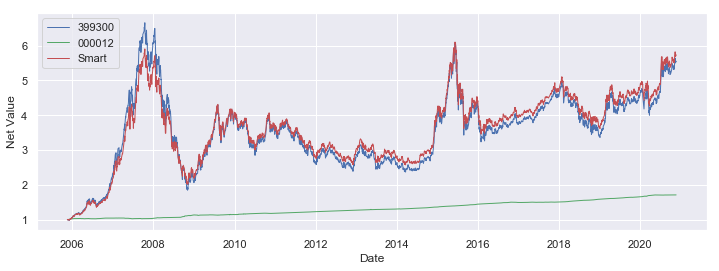

In [28]:
import tkinter as tk
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image,ImageTk
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
import pyecharts.options as opts
from pyecharts.charts import Line
import seaborn as sns
sns.set()

window=tk.Tk()
window.title("股债投资组合再平衡配置")
window.geometry('1000x500')
image = None
photo = None
# var = tk.StringVar()
l = tk.Label(window,text='请输入第一个金融工具代码(沪市请在前加0，深市请在前加1)：', bg='white', font=('宋体', 11), width=60, height=1)
l.grid(row=1, column=1)
e1 = tk.Entry(window, show=None, font=('Arial', 11)) 
e1.grid(row=1, column=2)

l2 = tk.Label(window,text='请输入第二个金融工具代码(沪市请在前加0，深市请在前加1)：', bg='white', font=('宋体', 11), width=60, height=1)
l2.grid(row=2, column=1)
e2 = tk.Entry(window, show=None, font=('Arial', 11))
e2.grid(row=2, column=2)

l3 = tk.Label(window,text='请输入起始日期(yyyy-mm-dd)：', bg='white', font=('宋体', 11), width=60, height=1)
l3.grid(row=3, column=1)
e3 = tk.Entry(window, show=None, font=('Arial', 11))
e3.grid(row=3, column=2)

l4 = tk.Label(window,text='请输入截止日期(yyyy-mm-dd)：', bg='white', font=('宋体', 11), width=60, height=1)
l4.grid(row=4, column=1)
e4 = tk.Entry(window, show=None, font=('Arial', 11))
e4.grid(row=4, column=2)

l5 = tk.Label(window,text='请输入第一个金融工具所占比例：', bg='white', font=('宋体', 11), width=60, height=1)
l5.grid(row=5, column=1)
e5 = tk.Entry(window, show=None, font=('Arial', 11))
e5.grid(row=5, column=2)

l6 = tk.Label(window,text='请输入第二个金融工具所占比例：', bg='white', font=('宋体', 11), width=60, height=1)
l6.grid(row=6, column=1)
e6 = tk.Entry(window, show=None, font=('Arial', 11))
e6.grid(row=6, column=2)

l7 = tk.Label(window,text='绘图如下所示：', bg='white', font=('宋体', 11), width=60, height=1)
l7.grid(row=7, column=1)

#设置画布
canvas = tk.Canvas(window, bg='white', height=300, width=800)
canvas.grid(row=8,rowspan=2,column=1,columnspan=2)

   
def get_input():
    code1=e1.get()#输入第一个投资工具
    code2=e2.get()#输入第二个投资工具
    begin_date=e3.get()#起始日期
    end_date=e4.get()#截止日期
    share1=e5.get()#开始时投资工具一的占比
    share2=e6.get()#开始时投资工具二的占比
    return code1,code2,begin_date,end_date,share1,share2


def Run():
    code1,code2,begin_date,end_date,share1,share2=get_input()
    download1=Download_HistoryStock(code1)
    download2=Download_HistoryStock(code2)
    download1.run()
    download2.run()
    idx_code1=code1[1::]#去掉沪市、深市的标志符
    idx_code2=code2[1::]
    share1=eval(share1)#将输入比例转换为float
    share2=eval(share2)
    
    ser1=get_data_ser(idx_code1,begin_date,end_date,"收盘价")
    ser1=ser1/ser1.iloc[0]
    ser2=get_data_ser(idx_code2,begin_date,end_date,"收盘价")
    ser2=ser2/ser2.iloc[0]
    
    comb_ser=get_stock_with_bond(idx_code1,share1,idx_code2,share2,begin_date,end_date)
    
        
    plt.figure(figsize=(12,4))
    plt.plot(ser1,"b",linewidth=1,label=idx_code1)
    plt.plot(ser2, "g",linewidth=1,label=idx_code2)
    plt.plot(comb_ser, "r",linewidth=1,label='Smart')
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Net Value")
    plt.savefig('myfig.jpg')
    plt.show()
    
    global image
    global photo
    window=tk.Tk()
    image = Image.open("myfig.jpg")
    photo = ImageTk.PhotoImage(image)
#     说明图片位置，并导入图片到画布上
#     #image_file = tk.PhotoImage(file='MyFig.png')  # 图片位置（相对路径，与.py文件同一文件夹下，也可以用绝对路径，需要给定图片具体绝对路径）
    canvas.create_image(400, 150, image=photo)
    

b = tk.Button(window, text='Run', font=('Arial', 12), width=10, height=1, command=Run)
b.grid(row=10, column=1)
window.mainloop()